In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,190 kB]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,625 kB]
Get:13 https://r2u.stat.illinois.edu/u

In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/new_train.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("new_train.csv"), sep=",", header=True)
df.show()

+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_location|dropoff_location|store_and_fwd_flag|trip_duration|   pickup_latitude|  pickup_longitude|  dropoff_latitude|dropoff_longitude|
+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+
|2024-01-03 22:50:16|2024-01-03 22:59:25|            1.0|             50|             236|                 N|          549|218437.82028573466| 985597.5343919232| 223613.7535760244|996155.3867656847|
|2024-01-25 09:33:05|2024-01-25 09:48:58|            1.0|            238|             230|                 N|          953|227717.51805898765| 991712.7644413216| 216099.1397683868|988628.0600467023|
|2024

In [5]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [6]:
from pyspark.sql.functions import col, hour, dayofmonth, dayofweek, to_timestamp

# Convert pickup_datetime to a timestamp
df = df.withColumn('pickup_datetime', to_timestamp(col('pickup_datetime')))

# Extract time-based features
df = df.withColumn('pickup_hour', hour(col('pickup_datetime')))
df = df.withColumn('pickup_day', dayofmonth(col('pickup_datetime')))
df = df.withColumn('pickup_weekday', dayofweek(col('pickup_datetime')))

# Show the updated DataFrame
df.show()


+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+-----------+----------+--------------+
|    pickup_datetime|   dropoff_datetime|passenger_count|pickup_location|dropoff_location|store_and_fwd_flag|trip_duration|   pickup_latitude|  pickup_longitude|  dropoff_latitude|dropoff_longitude|pickup_hour|pickup_day|pickup_weekday|
+-------------------+-------------------+---------------+---------------+----------------+------------------+-------------+------------------+------------------+------------------+-----------------+-----------+----------+--------------+
|2024-01-03 22:50:16|2024-01-03 22:59:25|            1.0|             50|             236|                 N|          549|218437.82028573466| 985597.5343919232| 223613.7535760244|996155.3867656847|         22|         3|             4|
|2024-01-25 09:33:05|2024-01-25 09:48:58|           

In [7]:
# Define features (X) and target (y)
X = df.drop('trip_duration')
y = df.select('trip_duration')


In [8]:
# Split the dataset into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [9]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType


In [10]:
train_data = train_data.withColumn('pickup_datetime', col('pickup_datetime').cast('timestamp'))
test_data = test_data.withColumn('pickup_datetime', col('pickup_datetime').cast('timestamp'))


In [15]:
from pyspark.ml.regression import RandomForestRegressor

# Define the Random Forest model with the correct parameters
rf = RandomForestRegressor(featuresCol='features', labelCol='trip_duration', numTrees=100)

In [16]:
train_data.printSchema()


root
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- pickup_location: string (nullable = true)
 |-- dropoff_location: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_weekday: integer (nullable = true)



In [17]:
from pyspark.ml.feature import VectorAssembler

# Assemble features
feature_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                   'dropoff_longitude', 'pickup_hour', 'pickup_day', 'pickup_weekday']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

In [20]:
from pyspark.sql.functions import col

# List of feature columns to cast
numeric_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']


In [21]:
# Cast each column to double
for column in numeric_columns:
    train_data = train_data.withColumn(column, col(column).cast('double'))
    test_data = test_data.withColumn(column, col(column).cast('double'))

In [22]:
# Transform the train and test datasets
train_data = assembler.transform(train_data).select('features', 'trip_duration')
test_data = assembler.transform(test_data).select('features', 'trip_duration')

In [23]:
train_data.select('features', 'trip_duration').show(5, truncate=False)


+-----------------------------------------------------------------------------------------+-------------+
|features                                                                                 |trip_duration|
+-----------------------------------------------------------------------------------------+-------------+
|[209708.74184834195,985089.2186553577,211948.91240008172,984272.7786326221,23.0,31.0,1.0]|163          |
|[223613.7535760244,996155.3867656847,221132.7753491493,989365.0684741095,23.0,31.0,1.0]  |920          |
|[218166.4343533099,996787.6630546569,218166.4343533099,996787.6630546569,0.0,1.0,2.0]    |169          |
|[203883.8201161869,982175.1477564898,203062.48265449997,1011322.0566218888,0.0,1.0,2.0]  |1348         |
|[214975.36687718582,993906.1723071609,183512.2660660261,989405.7462567874,0.0,1.0,2.0]   |1172         |
+-----------------------------------------------------------------------------------------+-------------+
only showing top 5 rows



In [27]:
from pyspark.sql.functions import col

# Cast trip_duration as double
train_data = train_data.withColumn('trip_duration', col('trip_duration').cast('double'))
test_data = test_data.withColumn('trip_duration', col('trip_duration').cast('double'))

In [28]:
model = rf.fit(train_data)


In [29]:
# Make Predictions
predictions = model.transform(test_data)

In [33]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the Model
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

In [34]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 2078.7378940637095
Mean Absolute Error (MAE): 410.6028743065651


In [36]:
import matplotlib.pyplot as plt

# Convert predictions to pandas for visualization
predictions_pandas = predictions.select('trip_duration', 'prediction').toPandas()
predictions_pandas.head()

,trip_duration,prediction
0,600.0,739.855816
1,1680.0,1565.118403
2,781.0,973.633131
3,1455.0,1694.396587
4,1585.0,1812.605058


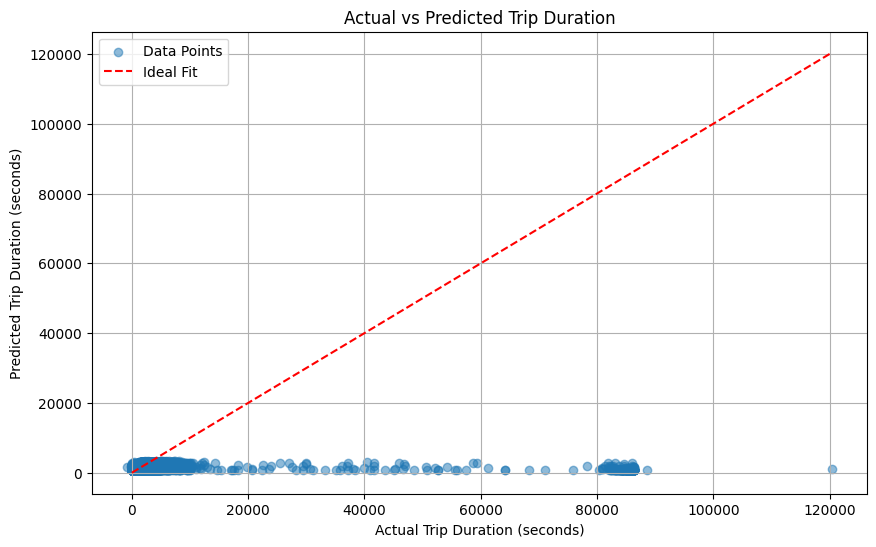

In [37]:
# Plot Actual vs. Predicted trip duration
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas['trip_duration'], predictions_pandas['prediction'], alpha=0.5, label='Data Points')
plt.plot([0, predictions_pandas['trip_duration'].max()],
         [0, predictions_pandas['trip_duration'].max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Actual vs Predicted Trip Duration')
plt.xlabel('Actual Trip Duration (seconds)')
plt.ylabel('Predicted Trip Duration (seconds)')
plt.legend()
plt.grid()
plt.show()

In [38]:
from pyspark.ml.regression import LinearRegression

# Define the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='trip_duration')

In [39]:
# Train the model
linear_model = lr.fit(train_data)

In [40]:
# Make predictions
linear_predictions = linear_model.transform(test_data)

In [41]:
# Evaluate the model
lr_rmse = evaluator.evaluate(linear_predictions)
lr_mae = evaluator.evaluate(linear_predictions, {evaluator.metricName: "mae"})

print(f"Linear Regression - Root Mean Squared Error (RMSE): {lr_rmse}")
print(f"Linear Regression - Mean Absolute Error (MAE): {lr_mae}")

Linear Regression - Root Mean Squared Error (RMSE): 2113.4881274584036
Linear Regression - Mean Absolute Error (MAE): 491.0751084747566
